In [1]:
#Import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import operator
from statistics import mode, mean

In [2]:
np.random.seed(1000)

In [3]:
# Part one
# Convert Data from pandas DataFrames to dictionary as keys and values
def data_split(data, normalized):
    x = {}
    y = {}
    for k, value in data.iterrows():
        if normalized:
            x[k] = [value['RI_Norm'], value['Na_Norm'], value['Mg_Norm'], value['Al_Norm'], value['Si_Norm'],
                    value['K_Norm'], value['Ca_Norm'], value['Ba_Norm'],
                    value['Fe_Norm']]
        else:
            x[k] = [value['RI'], value['Na'], value['Mg'], value['Al'], value['Si'], value['K'], value['Ca'],
                    value['Ba'],
                    value['Fe']]
        y[k] = int(value['Type'])
    return x, y


In [4]:
# Part two
# Convert Data from pandas DataFrames to dictionary as keys and values
def data_split_part2(data, normalized):
    x = {}
    y = {}
    # cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
    for k, value in data.iterrows():
        if normalized:
            x[k] = [value['cement_Norm'], value['slag_Norm'], value['flyash_Norm'], value['water_Norm'],
                    value['superplasticizer_Norm'],
                    value['coarseaggregate_Norm'], value['fineaggregate_Norm'], value['age_Norm']]
        else:
            x[k] = [value['cement'], value['slag'], value['flyash'], value['water'], value['superplasticizer'],
                    value['coarseaggregate'], value['fineaggregate'], value['age']]
        y[k] = int(value['csMPa'])

    return x, y

In [5]:
# Normalize datset
def normalization(non_normalized_data):
    minimum = min(non_normalized_data)
    maximum = max(non_normalized_data)
    return [(x - minimum) / (maximum - minimum) for x in non_normalized_data]

In [6]:
# Using numpy permutation to shuffle data
def shuffle_using_numpy(data):
    temp = np.random.permutation(len(data))
    return data.iloc[temp]

In [7]:
# Get euclidean_distance between features
def get_distance(node1, node2):
    distance = np.linalg.norm(np.array(node1) - np.array(node2))
    return distance

In [8]:
# Normalize (MIN MAX SCALING) 
def normalize_glass_data(glass):
    norm = normalization(glass['RI'].tolist())
    glass = glass.assign(RI_Norm=norm)

    norm = normalization(glass['Na'].tolist())
    glass = glass.assign(Na_Norm=norm)

    norm = normalization(glass['Mg'].tolist())
    glass = glass.assign(Mg_Norm=norm)

    norm = normalization(glass['Al'].tolist())
    glass = glass.assign(Al_Norm=norm)

    norm = normalization(glass['Si'].tolist())
    glass = glass.assign(Si_Norm=norm)

    norm = normalization(glass['K'].tolist())
    glass = glass.assign(K_Norm=norm)

    norm = normalization(glass['Ca'].tolist())
    glass = glass.assign(Ca_Norm=norm)

    norm = normalization(glass['Ba'].tolist())
    glass = glass.assign(Ba_Norm=norm)

    norm = normalization(glass['Fe'].tolist())
    glass = glass.assign(Fe_Norm=norm)
    return glass

In [9]:

# Normalize (MIN MAX SCALING)
def normalize_strength_dataset(con_data):
    norm = normalization(con_data['cement'].tolist())
    con_data = con_data.assign(cement_Norm=norm)

    norm = normalization(con_data['slag'].tolist())
    con_data = con_data.assign(slag_Norm=norm)

    norm = normalization(con_data['flyash'].tolist())
    con_data = con_data.assign(flyash_Norm=norm)

    norm = normalization(con_data['water'].tolist())
    con_data = con_data.assign(water_Norm=norm)

    norm = normalization(con_data['superplasticizer'].tolist())
    con_data = con_data.assign(superplasticizer_Norm=norm)

    norm = normalization(con_data['coarseaggregate'].tolist())
    con_data = con_data.assign(coarseaggregate_Norm=norm)

    norm = normalization(con_data['fineaggregate'].tolist())
    con_data = con_data.assign(fineaggregate_Norm=norm)

    norm = normalization(con_data['age'].tolist())
    con_data = con_data.assign(age_Norm=norm)
    return con_data



In [10]:
def nearest_neighbor(glass, weighted, K, normalized):
    folds = 5
    fold_size = len(glass) // folds
    start = 0
    accuracy = 0
    for k in range(1, folds + 1):
        test = pd.DataFrame(glass[start:fold_size * k])

        train = pd.DataFrame(data=None)
        frame2 = glass[fold_size * k:len(glass)]
        frame1 = glass[:start]

        start = start + fold_size

        if len(frame1) == 0:
            train = frame2
        elif len(frame2) == 0:
            train = frame1
        else:
            train = frame1.append(frame2, ignore_index=False)

            # train = glass - test
        x_train, y_train = data_split(train, normalized)
        x_test, y_test = data_split(test, normalized)
        local_accuracy = 0
        correct = 0
        for k_test, v_test in x_test.items():
            distance = []
            for k_train, v_train in x_train.items():
                euclidean_distance = get_distance(v_train, v_test)
                distance.append((euclidean_distance, k_train))

            distance = sorted(distance)[:K]
            weights = {}
            labels = []
            if weighted:  # Wieghted KNN
                # print("Index", k_test, "Dist", distance)
                for d in distance:
                    if d[0] != 0:
                        # print(d, y_train[d[1]])
                        labels.append(y_train[d[1]])
                        if y_train[d[1]] not in weights:
                            weights[y_train[d[1]]] = 1 / d[0]

                        else:
                            weights[y_train[d[1]]] += 1 / d[0]
              
                if weights:
                    if y_test[k_test] == max(weights.items(), key=operator.itemgetter(1))[0]:
                        correct += 1

            else:  # Normal KNN
                for d in distance:
                    labels.append(y_train[d[1]])
                if mode(labels) == y_test[k_test]:
                    correct += 1

        local_accuracy = 100 * (correct / len(x_test))
        accuracy += local_accuracy

    #         print("At at Fold", k, "Accuracy is =", local_accuracy)
    print("The accuracy of nearest_neighbor  after 5 k_folds is {}% \n\n".format(accuracy / 5))

    return accuracy / 5

In [12]:
glass = pd.read_csv("glass.csv")


In [13]:
# Shuffle and Normalize data set
glass = shuffle_using_numpy(glass)
glass = normalize_glass_data(glass)

In [14]:
# Train and test with(1,3,5,7,9)Ks, then save results  in arrays
non_weighted_non_norm1 = []
non_weighted_norm1 = []
weighted_non_norm1 = []
weighted_norm1 = []

# # part once Glass classification
for k in range(1, 11, 2):
    # With normalization
    print("When k equal = ",k)
    non_weighted_non_norm1.append("%.2f" % nearest_neighbor(glass, False, k, False))
    # weighted KNN
    non_weighted_norm1.append("%.2f" % nearest_neighbor(glass, False, k, True))
    # Without normalization
    weighted_non_norm1.append("%.2f" % nearest_neighbor(glass, True, k, False))
    # weighted KNN
    weighted_norm1.append("%.2f" % nearest_neighbor(glass, True, k, True))

print(non_weighted_non_norm1)
print(non_weighted_norm1)
print(weighted_non_norm1)
print(weighted_norm1)

When k equal =  1
The accuracy of nearest_neighbor  after 5 k_folds is 68.0952380952381% 


The accuracy of nearest_neighbor  after 5 k_folds is 66.19047619047618% 


The accuracy of nearest_neighbor  after 5 k_folds is 68.0952380952381% 


The accuracy of nearest_neighbor  after 5 k_folds is 66.19047619047618% 


When k equal =  3
The accuracy of nearest_neighbor  after 5 k_folds is 67.14285714285715% 


The accuracy of nearest_neighbor  after 5 k_folds is 66.66666666666667% 


The accuracy of nearest_neighbor  after 5 k_folds is 66.19047619047619% 


The accuracy of nearest_neighbor  after 5 k_folds is 66.66666666666667% 


When k equal =  5
The accuracy of nearest_neighbor  after 5 k_folds is 68.0952380952381% 


The accuracy of nearest_neighbor  after 5 k_folds is 65.23809523809524% 


The accuracy of nearest_neighbor  after 5 k_folds is 70.0% 


The accuracy of nearest_neighbor  after 5 k_folds is 66.19047619047619% 


When k equal =  7
The accuracy of nearest_neighbor  after 5 k_

In [15]:
import statistics

print(statistics.mean([float(i) for i in non_weighted_non_norm1] ))
print(statistics.mean( [float(i) for i in non_weighted_norm1] ))
print(statistics.mean([float(i) for i in weighted_non_norm1]))
print(statistics.mean([float(i) for i in weighted_norm1]))

66.096
64.476
67.42999999999999
65.81


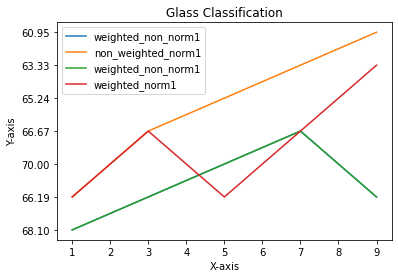

In [16]:
#Plot a line graph
x= [1,3,5,7,9]
plt.plot(x,weighted_non_norm1, label='weighted_non_norm1')
plt.plot(x,non_weighted_norm1, label='non_weighted_norm1')
plt.plot(x,weighted_non_norm1, label='weighted_non_norm1')
plt.plot(x,weighted_norm1, label='weighted_norm1')
plt.title("Interactive Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.title("Glass Classification")
plt.show()
